In [5]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from maad import sound, features, rois
from maad.util import power2dB, plot2d, format_features, overlay_rois
import os
import itertools
import math
import pandas as pd
import wave



Start by loading an example audio file. We will remove low frequency ambient noise with a lowpass filter and then compute the spectrogram.



In [6]:
std_values = [1.25]
bin_std_values = [1.3]
bin_per_values = [0.8]

(<Axes: xlabel='Time [s]', ylabel='Frequency [Hz]'>,
 <Figure size 1814.21x579.062 with 2 Axes>)

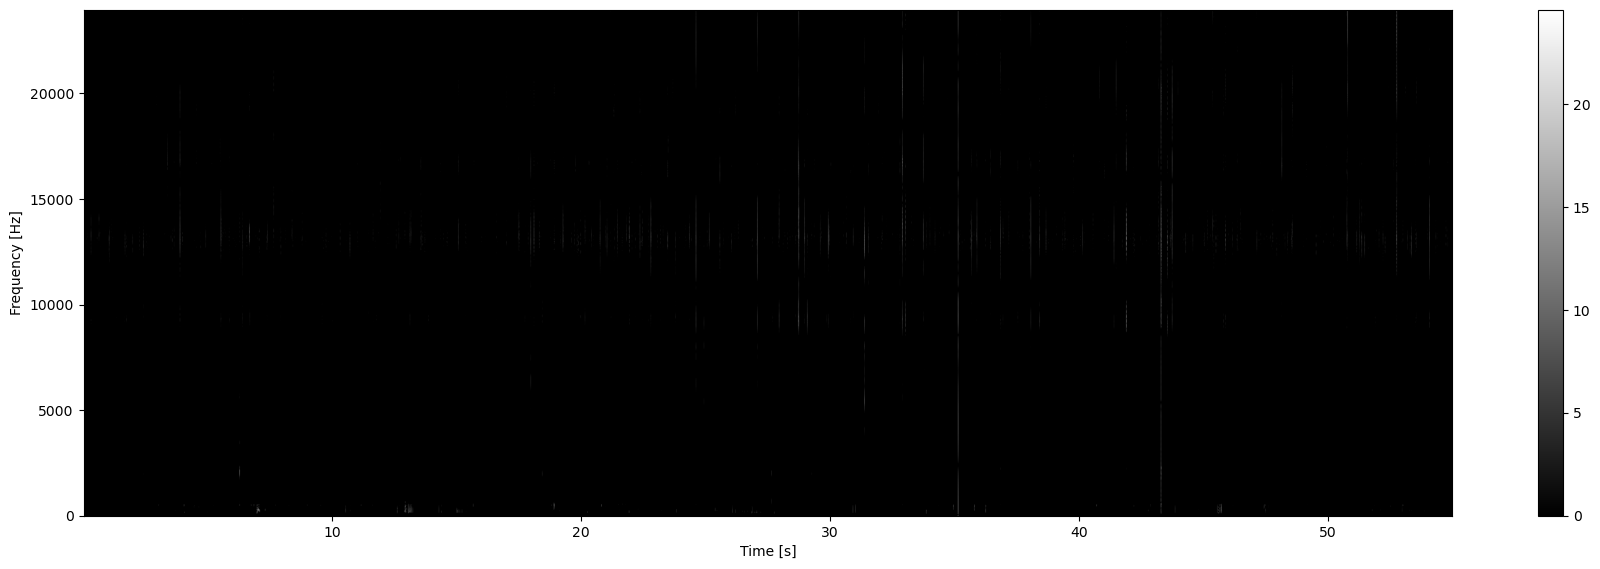

In [7]:
#Load Single File
s, fs = sound.load("C:/Users/ofsto/OneDrive/Desktop/Internship/WOPAM/Site 4.2.2/4.2.2_20211014_061700.WAV")
s_filt = sound.select_bandwidth(s, fs, fcut=100, forder=3, ftype='highpass')

db_max=70  # used to define the range of the spectrogram
Sxx, tn, fn, ext = sound.spectrogram(s_filt, fs, nperseg=1024, noverlap=512)
Sxx_db = power2dB(Sxx, db_range=db_max) + db_max
plot2d(Sxx_db, **{'extent':ext})

### 1. Find regions of interest




In [8]:
freq_threshold = 2000

def sound_under_2000hz(min_freq, max_freq):
    return max_freq <= freq_threshold

In [9]:
Sxx_db_rmbg, _, _ = sound.remove_background(Sxx_db)
Sxx_db_smooth = sound.smooth(Sxx_db_rmbg, std=1.25)
im_mask = rois.create_mask(im=Sxx_db_smooth, mode_bin ='relative', bin_std=1.3, bin_per=0.8)
im_rois, df_rois = rois.select_rois(im_mask, min_roi=50, max_roi=None)


df_rois

,labelID,label,min_y,min_x,max_y,max_x
0,1,unknown,0,647,13,665
1,2,unknown,0,1176,11,1182
2,3,unknown,0,1203,16,1241
3,5,unknown,0,2511,11,2519
4,6,unknown,0,2521,7,2538
...,...,...,...,...,...,...
310,488,unknown,473,3562,511,3568
311,490,unknown,490,3090,511,3096
312,491,unknown,492,3078,511,3084
313,493,unknown,496,4246,511,4256


In [10]:
# Format ROIs and visualize the bounding box on the audio spectrogram.
df_rois = format_features(df_rois, tn, fn)

df_rois

,labelID,label,min_y,min_x,max_y,max_x,min_f,min_t,max_f,max_t
0,1,unknown,0,647,13,665,0.000,6.912000,609.375,7.104000
1,2,unknown,0,1176,11,1182,0.000,12.554667,515.625,12.618667
2,3,unknown,0,1203,16,1241,0.000,12.842667,750.000,13.248000
3,5,unknown,0,2511,11,2519,0.000,26.794667,515.625,26.880000
4,6,unknown,0,2521,7,2538,0.000,26.901333,328.125,27.082667
...,...,...,...,...,...,...,...,...,...,...
310,488,unknown,473,3562,511,3568,22171.875,38.005333,23953.125,38.069333
311,490,unknown,490,3090,511,3096,22968.750,32.970667,23953.125,33.034667
312,491,unknown,492,3078,511,3084,23062.500,32.842667,23953.125,32.906667
313,493,unknown,496,4246,511,4256,23250.000,45.301333,23953.125,45.408000


In [11]:
df_rois_filtered = df_rois[df_rois.apply(lambda row: sound_under_2000hz(row['min_f'], row['max_f']), axis=1)]

In [12]:
df_rois_filtered

,labelID,label,min_y,min_x,max_y,max_x,min_f,min_t,max_f,max_t
0,1,unknown,0,647,13,665,0.000,6.912000,609.375,7.104000
1,2,unknown,0,1176,11,1182,0.000,12.554667,515.625,12.618667
2,3,unknown,0,1203,16,1241,0.000,12.842667,750.000,13.248000
3,5,unknown,0,2511,11,2519,0.000,26.794667,515.625,26.880000
4,6,unknown,0,2521,7,2538,0.000,26.901333,328.125,27.082667
5,8,unknown,0,2892,12,2898,0.000,30.858667,562.500,30.922667
6,9,unknown,0,3168,8,3174,0.000,33.802667,375.000,33.866667
9,12,unknown,0,4264,14,4286,0.000,45.493333,656.250,45.728000
10,13,unknown,1,373,13,381,46.875,3.989333,609.375,4.074667
11,14,unknown,1,982,12,988,46.875,10.485333,562.500,10.549333


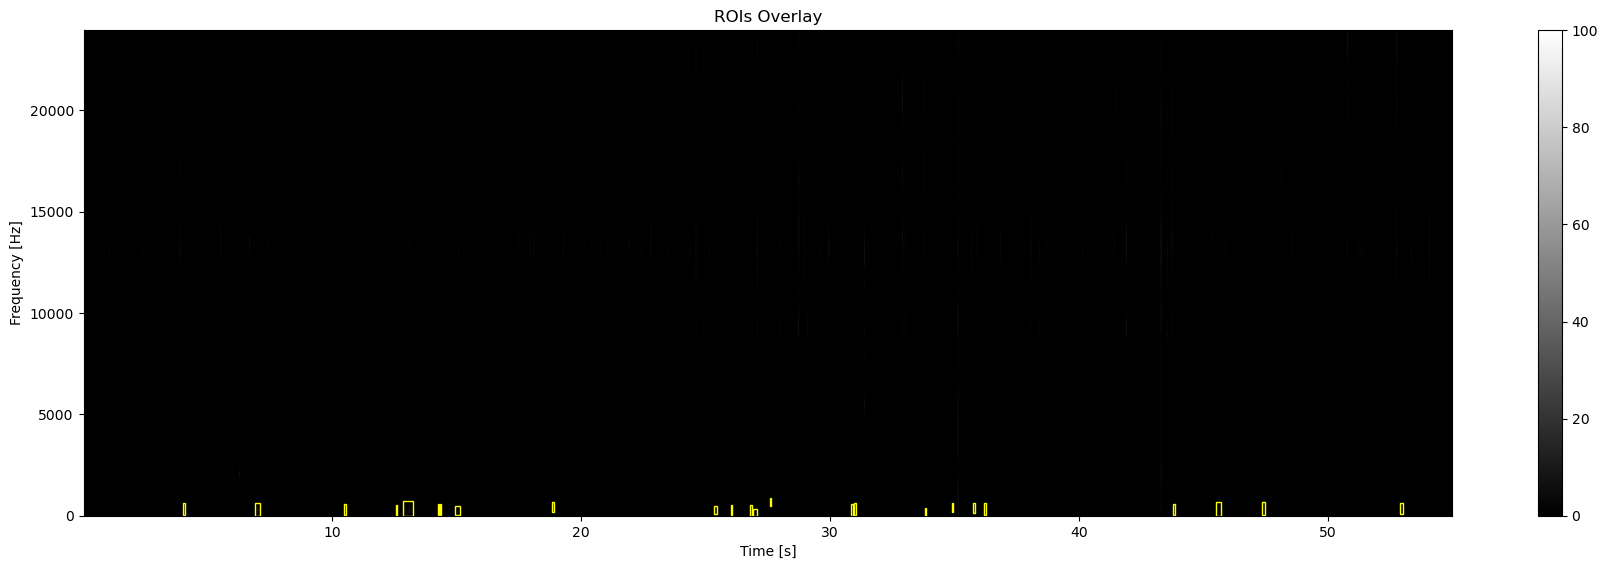

In [13]:
ax0, fig0 = overlay_rois(Sxx_db, df_rois_filtered, **{'vmin':0, 'vmax':100, 'extent':ext})


In [14]:
import pandas as pd

def adjust_clips_to_5_seconds(df, clip_duration=55):
    # Set the fixed duration for the adjusted clips
    fixed_clip_duration = 5.0
    
    # Copy the dataframe to avoid modifying the original one
    df_adjusted = df.copy()

    for index, row in df_adjusted.iterrows():
        # Calculate the current duration
        current_duration = row['max_t'] - row['min_t']
        
        # Calculate new start time (1 second earlier)
        new_start_time = max(row['min_t'] - 1, 0)
        
        # Calculate the end time to make the clip exactly 5 seconds
        new_end_time = new_start_time + fixed_clip_duration

        # Ensure new_end_time doesn't exceed the total clip duration
        if new_end_time > clip_duration:
            new_end_time = clip_duration
            new_start_time = max(new_end_time - fixed_clip_duration, 0)
        
        # Calculate the proportion of the time change
        start_time_change_proportion = (new_start_time - row['min_t']) / current_duration
        end_time_change_proportion = (new_end_time - row['max_t']) / current_duration
        
        # Adjust min_x and max_x based on the time changes
        new_min_x = row['min_x'] + (row['max_x'] - row['min_x']) * start_time_change_proportion
        new_max_x = row['max_x'] + (row['max_x'] - row['min_x']) * end_time_change_proportion
        
        # Adjust the DataFrame with new start and end times, and x coordinates
        df_adjusted.at[index, 'min_t'] = new_start_time
        df_adjusted.at[index, 'max_t'] = new_end_time
        df_adjusted.at[index, 'min_x'] = new_min_x
        df_adjusted.at[index, 'max_x'] = new_max_x
    
    return df_adjusted


In [15]:
df_rois_filtered_adjusted = adjust_clips_to_5_seconds(df_rois_filtered)

In [16]:
df_rois_filtered

,labelID,label,min_y,min_x,max_y,max_x,min_f,min_t,max_f,max_t
0,1,unknown,0,647,13,665,0.000,6.912000,609.375,7.104000
1,2,unknown,0,1176,11,1182,0.000,12.554667,515.625,12.618667
2,3,unknown,0,1203,16,1241,0.000,12.842667,750.000,13.248000
3,5,unknown,0,2511,11,2519,0.000,26.794667,515.625,26.880000
4,6,unknown,0,2521,7,2538,0.000,26.901333,328.125,27.082667
5,8,unknown,0,2892,12,2898,0.000,30.858667,562.500,30.922667
6,9,unknown,0,3168,8,3174,0.000,33.802667,375.000,33.866667
9,12,unknown,0,4264,14,4286,0.000,45.493333,656.250,45.728000
10,13,unknown,1,373,13,381,46.875,3.989333,609.375,4.074667
11,14,unknown,1,982,12,988,46.875,10.485333,562.500,10.549333


In [17]:
df_rois_filtered_adjusted

,labelID,label,min_y,min_x,max_y,max_x,min_f,min_t,max_f,max_t
0,1,unknown,0,553.25,13,1022.00,0.000,5.912000,609.375,10.912000
1,2,unknown,0,1082.25,11,1551.00,0.000,11.554667,515.625,16.554667
2,3,unknown,0,1109.25,16,1578.00,0.000,11.842667,750.000,16.842667
3,5,unknown,0,2417.25,11,2886.00,0.000,25.794667,515.625,30.794667
4,6,unknown,0,2427.25,7,2896.00,0.000,25.901333,328.125,30.901333
5,8,unknown,0,2798.25,12,3267.00,0.000,29.858667,562.500,34.858667
6,9,unknown,0,3074.25,8,3543.00,0.000,32.802667,375.000,37.802667
9,12,unknown,0,4170.25,14,4639.00,0.000,44.493333,656.250,49.493333
10,13,unknown,1,279.25,13,748.00,46.875,2.989333,609.375,7.989333
11,14,unknown,1,888.25,12,1357.00,46.875,9.485333,562.500,14.485333


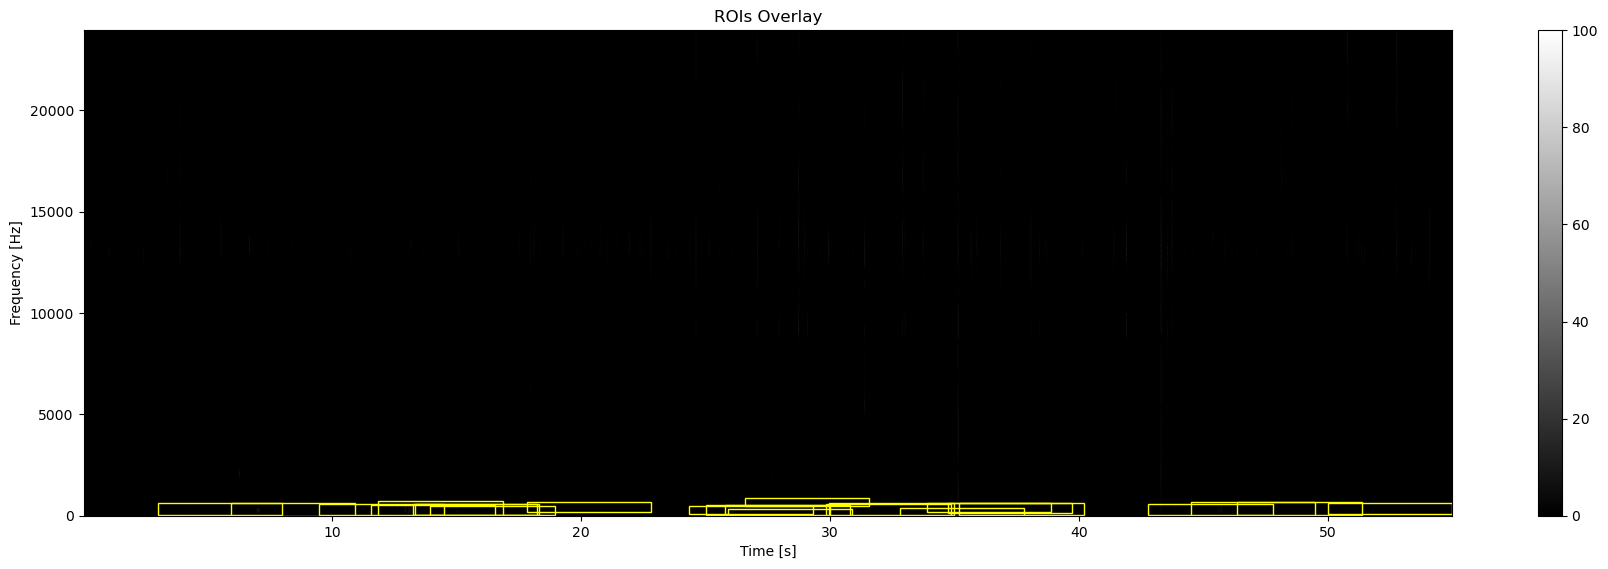

In [18]:
ax0, fig0 = overlay_rois(Sxx_db, df_rois_filtered_adjusted, **{'vmin':0, 'vmax':100, 'extent':ext})

In [19]:
def save_clips_to_directory(df, audio_file_path, output_directory):
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)
    
    # Open the original audio file
    with wave.open(audio_file_path, 'rb') as audio_file:
        params = audio_file.getparams()
        frame_rate = params.framerate
        num_channels = params.nchannels
        sample_width = params.sampwidth
        
        for index, row in df.iterrows():
            # Calculate start and end frames
            start_frame = int(row['min_t'] * frame_rate)
            end_frame = int(row['max_t'] * frame_rate)
            num_frames = end_frame - start_frame
            
            # Set output file path
            output_file_path = os.path.join(output_directory, f"clip_{row['labelID']}.wav")
            
            # Create a new wave file and write the frames
            with wave.open(output_file_path, 'wb') as output_file:
                output_file.setnchannels(num_channels)
                output_file.setsampwidth(sample_width)
                output_file.setframerate(frame_rate)
                
                # Set the position to start_frame and read the data
                audio_file.setpos(start_frame)
                frames = audio_file.readframes(num_frames)
                
                # Write the frames to the new file
                output_file.writeframes(frames)
    
    print(f"Clips saved to {output_directory}")

In [20]:
save_clips_to_directory(df_rois_filtered_adjusted, "C:/Users/ofsto/OneDrive/Desktop/Internship/WOPAM/Site 4.2.2/4.2.2_20211014_061700.WAV", "C:/Users/ofsto/OneDrive/Desktop/Internship/Aqoustics-Unsupervised/data")

Clips saved to C:/Users/ofsto/OneDrive/Desktop/Internship/Aqoustics-Unsupervised/data


## 2. Compute acoustic features




In [28]:
df_shape, params = features.shape_features(Sxx_db, resolution='low', rois=df_rois_filtered)
df_centroid = features.centroid_features(Sxx_db, df_rois)

# Get median frequency and normalize
median_freq = fn[np.round(df_centroid.centroid_y).astype(int)]
df_centroid['centroid_freq'] = median_freq/fn[-1]

## 3. Reduce the dimensionality of the features
The shape audio features have 26 dimensions. To facilitate the clustering process and visualize the results, it is posible to use non-metric dimensionality reduction algorithm, namely the t-distributed stochastic neighbor embedding (t-SNE), to proyect the data in two dimensions.



[t-SNE] Computing 23 nearest neighbors...
[t-SNE] Indexed 24 samples in 0.000s...
[t-SNE] Computed neighbors for 24 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 0.964006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.508522
[t-SNE] KL divergence after 1000 iterations: 0.053865


Text(0, 0.5, 'tsne dim 2')

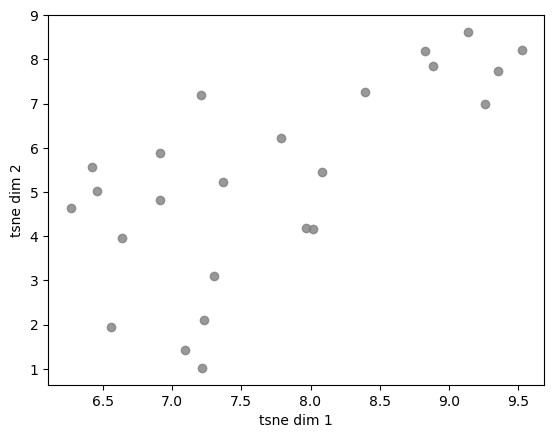

In [29]:
from sklearn.manifold import TSNE

X = df_shape.loc[:,df_shape.columns.str.startswith('shp')]
X = X.join(df_centroid.centroid_freq) # add column and normalize values

tsne = TSNE(n_components=2, perplexity=12, init='pca', verbose=True)
Y = tsne.fit_transform(X)

fig, ax = plt.subplots()
ax.scatter(Y[:,0], Y[:,1], c='gray', alpha=0.8)
ax.set_xlabel('tsne dim 1')
ax.set_ylabel('tsne dim 2')

## 4. Cluster the ROIs into homogeneous groups. 

In [30]:
from sklearn.cluster import DBSCAN
cluster = DBSCAN(eps=1, min_samples=3).fit(Y)
print('Number of soundtypes found:', np.unique(cluster.labels_).size)

Number of soundtypes found: 4


Visualize the clustering results



C:\Users\ofsto\AppData\Local\Temp\ipykernel_16996\148633834.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rois_filtered['label'] = cluster.labels_.astype(str)


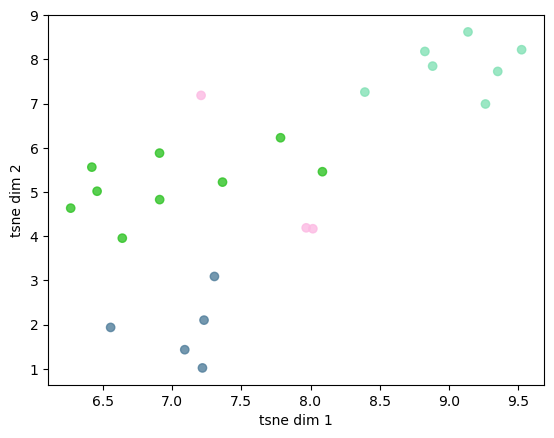

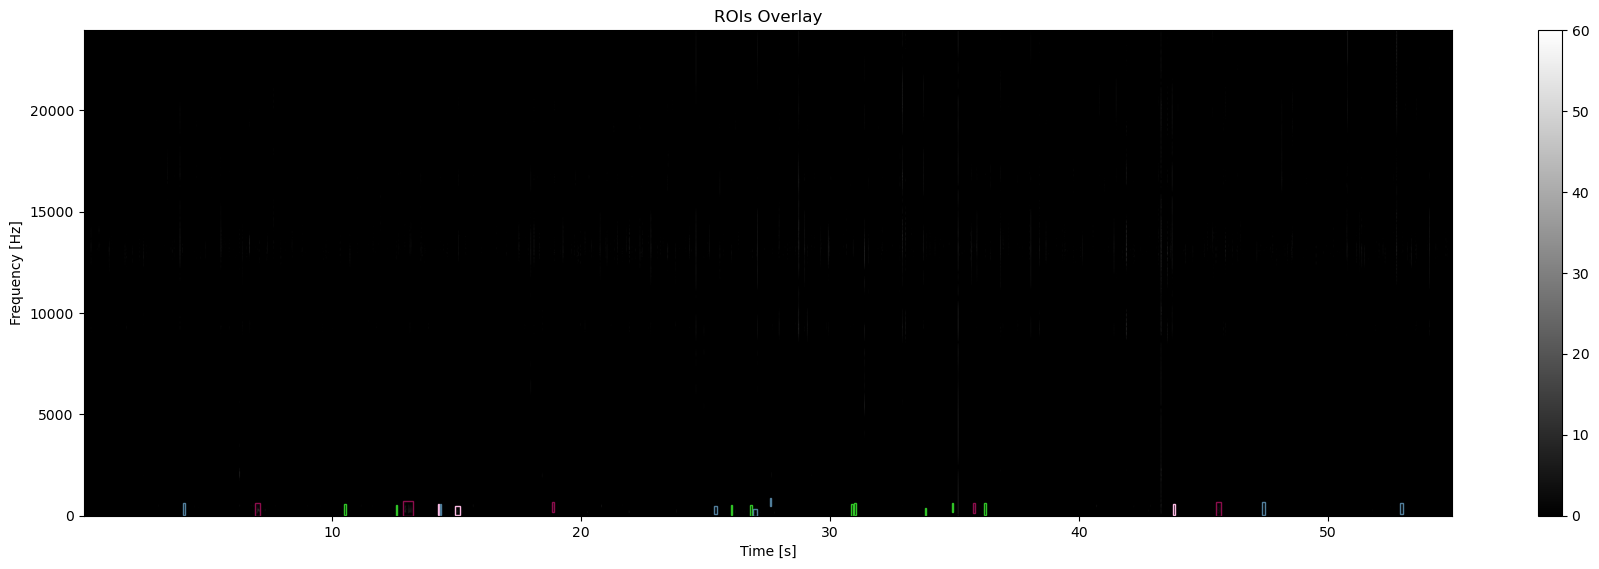

In [33]:
from maad.util import rand_cmap
fig, ax = plt.subplots()
ax.scatter(Y[:,0], Y[:,1], c=cluster.labels_, cmap=rand_cmap(5 , first_color_black=False), alpha=0.8)
ax.set_xlabel('tsne dim 1')
ax.set_ylabel('tsne dim 2')

# Overlay bounding box on the original spectrogram
df_rois_filtered['label'] = cluster.labels_.astype(str)
ax0, fig0 = overlay_rois(Sxx_db, df_rois_filtered, **{'vmin':0, 'vmax':60, 'extent':ext})